In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt 
import yfinance as yf  
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import itertools 
from PIL.GimpGradientFile import linear
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import mutual_info_classif, RFE


In [3]:
unh = pd.read_csv('UNH.csv', parse_dates=['Date'], index_col='Date')
unh.dropna()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,505.082031,0.0,505.653107,488.846241,496.171553,0.0,5922900.0
2024-01-23,507.573059,0.0,510.093593,504.186086,504.599594,0.0,2672900.0
2024-01-24,505.318329,0.0,513.687298,505.042676,509.916382,0.0,2918800.0
2024-01-25,485.794037,0.0,487.871526,471.616025,480.073603,0.0,14671000.0
2024-01-26,495.442963,0.0,495.925400,482.347970,485.675871,0.0,6212200.0
...,...,...,...,...,...,...,...
2025-01-10,520.690002,0.0,535.450012,518.469971,526.640015,0.0,5467500.0
2025-01-13,541.140015,0.0,547.400024,533.140015,535.039978,0.0,6472500.0
2025-01-14,543.739990,0.0,544.549988,536.549988,539.650024,0.0,3978300.0


Train Test Split Function

In [ ]:
def train_test_split_macd(df):

    # Define the training and trading periods
    train_start, train_end = '2024-01-17', '2024-02-29'
    trade_start, trade_end = '2024-03-01', '2025-01-16'

    # Filter the dataset for the training and trading periods
    df_train = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)].copy()
    df_trade = df[(df['Date'] >= trade_start) & (df['Date'] <= trade_end)].copy()

    return df_train, df_trade

MACD Strategy 

In [ ]:
# Function to calculate MACD and Signal Line with fixed parameters
def calculate_macd(df, short_window=4, long_window=9, signal_window=6):
    df['EMA_Short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_Long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_Short'] - df['EMA_Long']
    df['Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

# Function to implement MACD strategy and compute returns
def macd_strategy(df):
    df = calculate_macd(df)
    
    # Set positions based on MACD crossover signals
    df['Position'] = 0.0
    df.loc[df['MACD'] > df['Signal'], 'Position'] = 1.0  # Buy
    df.loc[df['MACD'] < df['Signal'], 'Position'] = -0.5  # Short
    
    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().fillna(0)

    # Ensure Dividends column exists and handle missing values
    df['Dividends'] = pd.to_numeric(df.get('Dividends', 0), errors='coerce').fillna(0.0)

    # Adjust for reinvested dividends
    df['DividendsAdjustment'] = df['Position'] * (df['Dividends'] / df['Close'])

    # Compute strategy returns
    df['StrategyReturns'] = (df['Position'].shift(1) * df['Returns']) + df['DividendsAdjustment']
    df['StrategyReturns'] = df['StrategyReturns'].fillna(0)

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

    total_return = df['CumulativeReturns'].iloc[-1]
    
    return total_return, df

# Function to plot MACD strategy results
def plot_macd_strategy(df, best_params):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='tab:gray', linestyle='dotted')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'MACD Strategy - Price & Positions (Short={best_params[0]}, Long={best_params[1]}, Signal={best_params[2]})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['CumulativeReturns'], label='MACD Strategy', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('MACD Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Conduct grid search over MACD parameters
try:
    short_windows = range(3, 7, 1)  # Short EMA range (3 to 6)
    long_windows = range(8, 12, 1)  # Long EMA range (8 to 11)
    signal_windows = range(5, 8, 1)  # Signal EMA range (5 to 7)
    
    best_params = None
    best_return = -np.inf
    results = {}

    for short in short_windows:
        for long in long_windows:
            for signal in signal_windows:
                df_temp = unh.copy()
                df_temp = calculate_macd(df_temp, short, long, signal)
                total_return, _ = macd_strategy(df_temp)
                results[(short, long, signal)] = total_return

                if total_return > best_return:
                    best_return = total_return
                    best_params = (short, long, signal)

    # Apply the best MACD strategy to UNH data
    _, best_macd_df = macd_strategy(unh)

    # Plot the strategy results using the new function
    plot_macd_strategy(best_macd_df, best_params)

    # Print the best MACD parameters and corresponding return
    print("Short EMA\tLong EMA\tSignal EMA\tTotal Return")
    for params, ret in results.items():
        print(f"{params[0]}\t\t{params[1]}\t\t{params[2]}\t\t{ret:.2%}")
    print(f"\nBest MACD parameters for UNH: Short={best_params[0]}, Long={best_params[1]}, Signal={best_params[2]} with Total Return: {best_return:.2%}")




SyntaxError: incomplete input (2120402301.py, line 108)

RSI Strategy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3061891337.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3061891337.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3061891337.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change()
C:\Users\ASUS\Ap

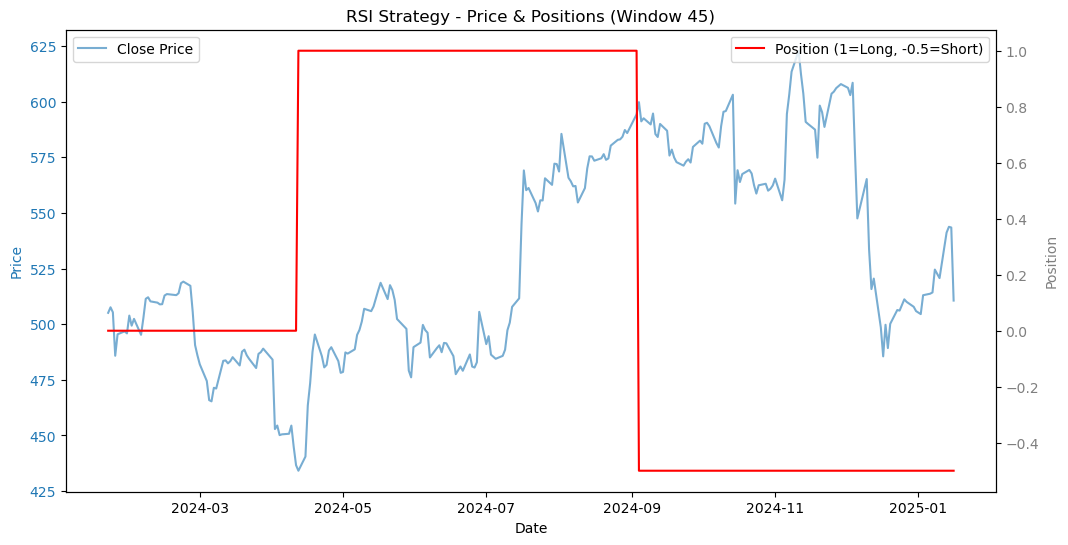

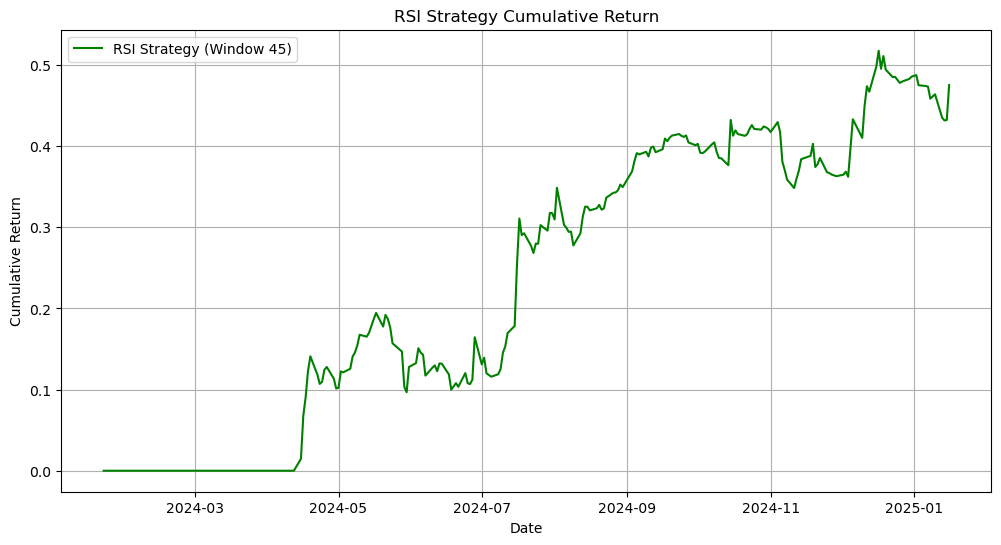

RSI Window	Total Return
5		18.05%
10		34.48%
15		33.12%
20		17.82%
25		15.04%
30		11.81%
35		36.95%
40		42.11%
45		47.54%
50		0.00%

Best RSI window for UNH: 45 with Total Return: 47.54%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to compute RSI for a given series and window
def compute_RSI(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to build the RSI strategy with long and short positions
def rsi_strategy(df, window, oversold=30, overbought=70):
    df = df.copy()
    df['RSI'] = compute_RSI(df['Close'], window)

    # Generate trading signals: +1 for long, -0.5 for short
    df['Signal'] = 0
    df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
    df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

    # Carry forward the last signal until a new signal appears
    df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['Position'].shift(1) * df['Returns']
    df['Strategy_Returns'].fillna(0, inplace=True)

    # Compute cumulative returns
    df['Cumulative_Return'] = (1 + df['Strategy_Returns']).cumprod() - 1
    total_return = df['Cumulative_Return'].iloc[-1]

    return total_return, df

# Function to plot strategy results, including price, position, and cumulative returns
def plot_rsi_strategy(df, best_window):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'RSI Strategy - Price & Positions (Window {best_window})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative_Return'], label=f'RSI Strategy (Window {best_window})', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('RSI Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to perform grid search over RSI windows
def find_best_rsi_window(df, window_range):
    results = {}
    for window in window_range:
        total_return, _ = rsi_strategy(df, window)
        results[window] = total_return
    best_window = max(results, key=results.get)
    _, best_strategy_df = rsi_strategy(df, best_window)
    return best_window, results, best_strategy_df

# Example usage (make sure 'unh' DataFrame with 'Close' and datetime index is already defined)
window_range = range(5, 51, 5)
best_window, results, best_strategy_df = find_best_rsi_window(unh, window_range)
plot_rsi_strategy(best_strategy_df, best_window)

# Print the best RSI window and corresponding return
print("RSI Window\tTotal Return")
for w, ret in results.items():
    print(f"{w}\t\t{ret:.2%}")
print(f"\nBest RSI window for UNH: {best_window} with Total Return: {results[best_window]:.2%}")



SMA Strategy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3041321543.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3041321543.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\3041321543.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_

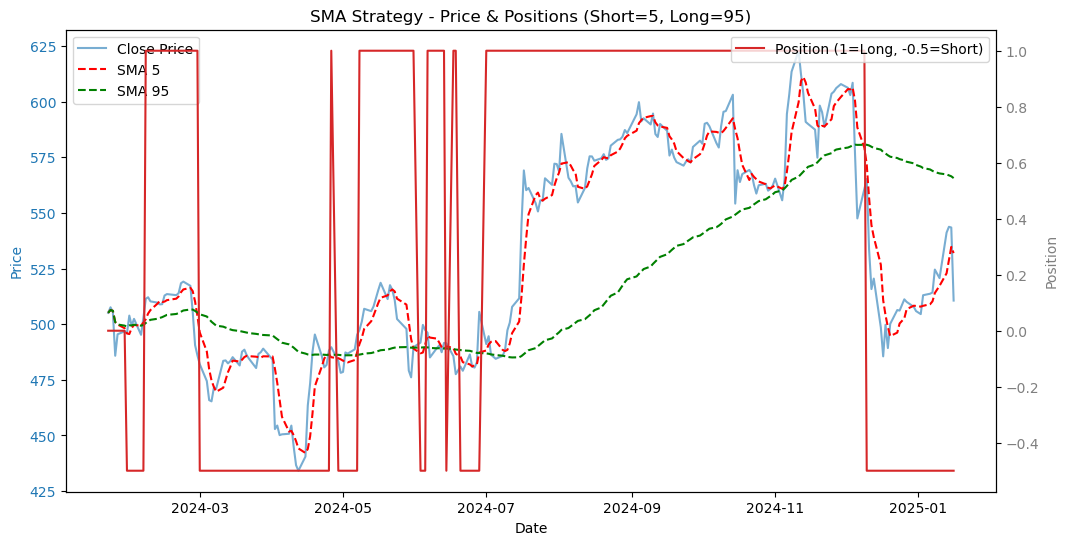

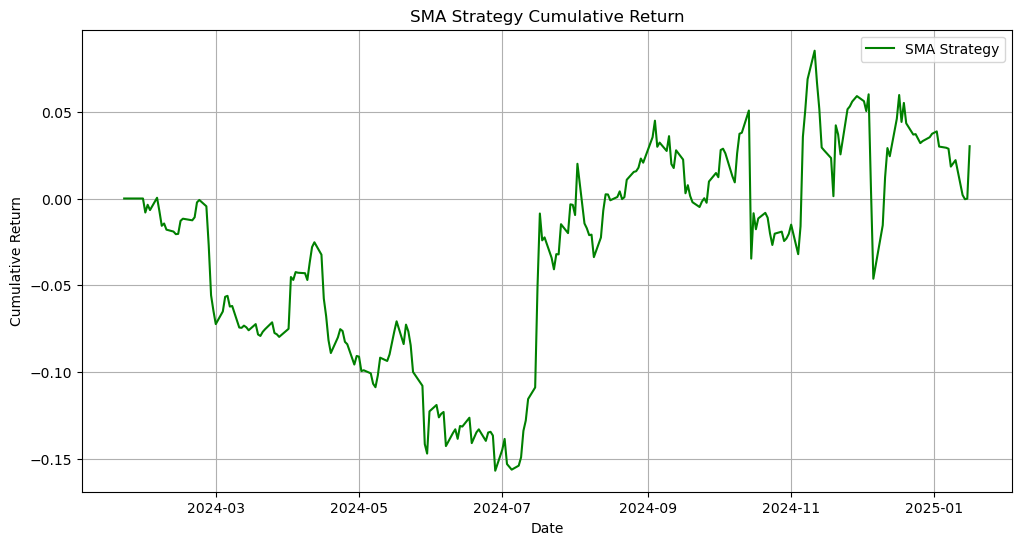

Short SMA	Long SMA	Total Return
5		30		-7.10%
5		35		-11.48%
5		40		-10.02%
5		45		-11.29%
5		50		-12.37%
5		55		-7.73%
5		60		-13.12%
5		65		-8.56%
5		70		-8.97%
5		75		-7.25%
5		80		-8.48%
5		85		-10.24%
5		90		-9.00%
5		95		3.01%
5		100		1.90%
7		30		-5.00%
7		35		-17.21%
7		40		-28.77%
7		45		-30.59%
7		50		-31.17%
7		55		-27.10%
7		60		-17.92%
7		65		-17.43%
7		70		-19.60%
7		75		-22.50%
7		80		-22.50%
7		85		-18.96%
7		90		-23.96%
7		95		-12.69%
7		100		-12.69%
9		30		-18.76%
9		35		-25.20%
9		40		-32.02%
9		45		-38.71%
9		50		-30.80%
9		55		-29.69%
9		60		-22.34%
9		65		-21.80%
9		70		-25.18%
9		75		-23.87%
9		80		-17.34%
9		85		-25.84%
9		90		-24.43%
9		95		-11.69%
9		100		-10.70%
11		30		-23.02%
11		35		-24.13%
11		40		-29.48%
11		45		-27.97%
11		50		-26.39%
11		55		-25.95%
11		60		-15.62%
11		65		-11.00%
11		70		-14.84%
11		75		-15.65%
11		80		-19.89%
11		85		-19.71%
11		90		-23.06%
11		95		-8.19%
11		100		-13.33%
13		30		-13.81%
13		35		-20.49%
13		40		-31.69%
13		45		-27.79

In [ ]:
# Function to calculate SMA (Simple Moving Average)
def calculate_sma(df, short_window, long_window):
    df['SMA_Short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return df

# Function to implement SMA strategy and compute returns
def sma_strategy(df, short_window, long_window):
    df = calculate_sma(df, short_window, long_window)
    
    # Set positions based on SMA crossover signals
    df['Position'] = 0.0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Position'] = 1.0  # Buy signal
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Position'] = -0.5  # Short signal (modified from -1 to -0.5)
    
    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().fillna(0)

    # Compute strategy returns
    df['StrategyReturns'] = df['Position'].shift(1) * df['Returns']
    df['StrategyReturns'] = df['StrategyReturns'].fillna(0)

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

    total_return = df['CumulativeReturns'].iloc[-1]
    
    return total_return, df

# Function to plot SMA strategy results
def plot_sma_strategy(df, best_params):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price and moving averages
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.plot(df.index, df['SMA_Short'], label=f'SMA {best_params[0]}', color='red', linestyle='dashed')
    ax1.plot(df.index, df['SMA_Long'], label=f'SMA {best_params[1]}', color='green', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'SMA Strategy - Price & Positions (Short={best_params[0]}, Long={best_params[1]})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['CumulativeReturns'], label='SMA Strategy', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('SMA Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show() 

def sma_grid_search(df, short_windows=range(5, 21, 2), long_windows=range(30, 101, 5)):
    best_params = None
    best_return = -np.inf
    results = {}

    for short in short_windows:
        for long in long_windows:
            if short >= long:
                continue  # Skip invalid cases where short SMA >= long SMA
            total_return, _ = sma_strategy(df, short, long)
            results[(short, long)] = total_return

            if total_return > best_return:
                best_return = total_return
                best_params = (short, long)

    return best_params, best_return, results 

best_sma_params, best_sma_return, sma_results = sma_grid_search(unh) 
_, best_sma_df = sma_strategy(unh, *best_sma_params) 
# Plot the strategy results using the existing function
plot_sma_strategy(best_sma_df, best_sma_params)

# Print the best SMA parameters and corresponding return
print("Short SMA\tLong SMA\tTotal Return")
for params, ret in sma_results.items():
    print(f"{params[0]}\t\t{params[1]}\t\t{ret:.2%}")
print(f"\nBest SMA parameters for UNH: Short={best_sma_params[0]}, Long={best_sma_params[1]} with Total Return: {best_sma_return:.2%}")

Linear Regression Strategy

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RSI']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\2918905329.py:133: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RSI']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_31556\2918905329.py:133: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be remove

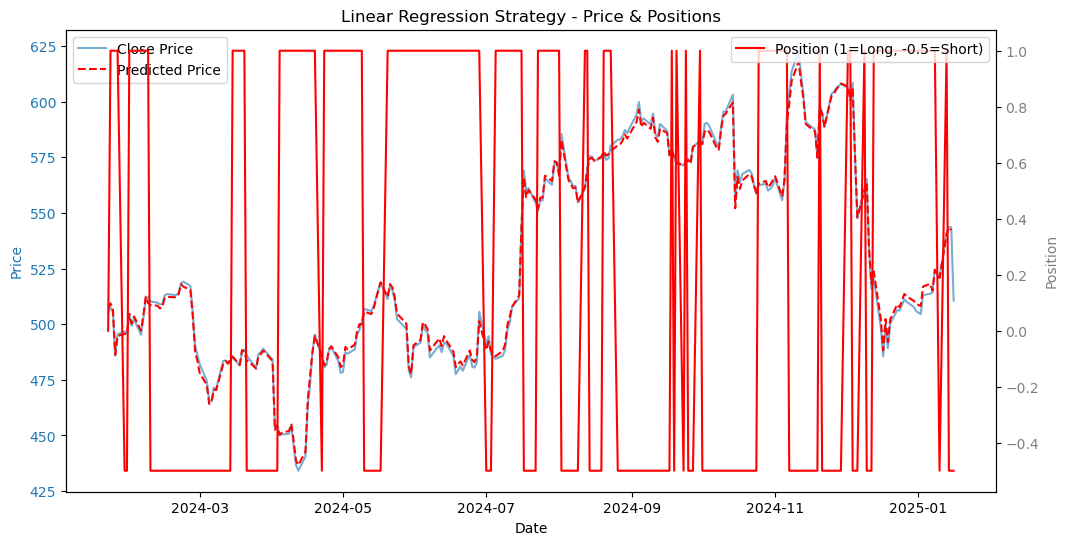

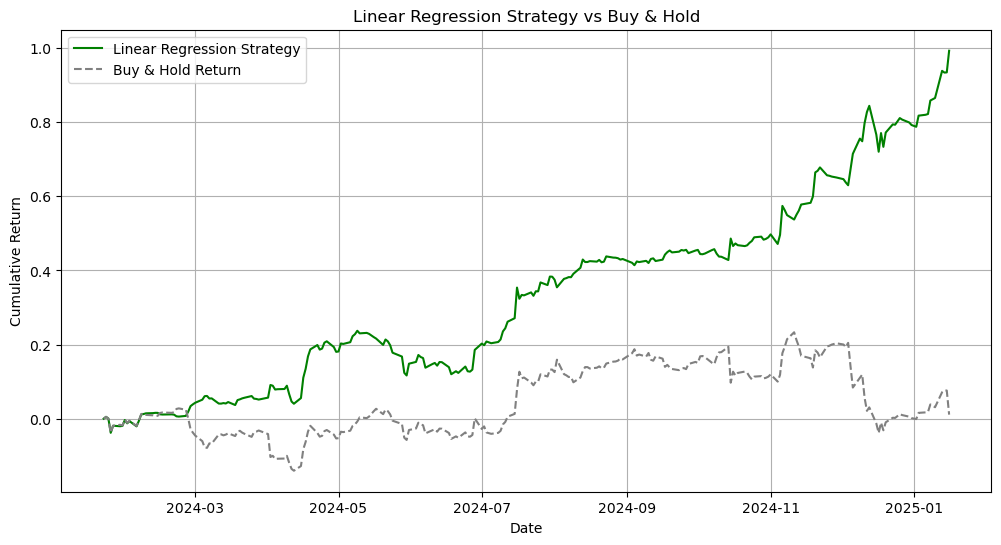


Evaluation Metrics:
Mean Squared Error (MSE):  85.1282
Root Mean Squared Error:   9.2265
Mean Absolute Error (MAE): 6.1642
R² Score:                  0.9595
Directional Accuracy:      52.23%

Feature Count	Total Return
3		55.37%
4		96.06%
5		76.70%
6		71.66%
7		99.31%
8		71.51%
9		60.30%
10		78.70%
11		64.60%

Best number of features: 7 with Total Return: 99.31%
Summary
Buy & Hold Return: 1.09%
Linear Regression Strategy Return: 99.31%
Perfect Strategy Return: 778.85%


In [ ]:
def calculate_indicators(df):
    df = df.copy()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()    
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Aroon Up & Aroon Down
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df


# Function to perform grid search over the number of selected features
def grid_search_feature_selection(df, feature_range=range(3, 12)):  # Testing from 3 to 11 features
    best_num_features = None
    best_return = -np.inf
    results = {}

    for num_features in feature_range:
        total_return, _ = linear_regression_strategy_with_features(df, num_features)
        results[num_features] = total_return

        if total_return > best_return:
            best_return = total_return
            best_num_features = num_features

    return best_num_features, best_return, results

# Function to implement linear regression strategy with variable feature selection
def linear_regression_strategy_with_features(df, num_features):
    df = calculate_indicators(df)

    # Define features and target
    feature_columns = ['RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA', 'SMA_EMA_Ratio',
                       'OBV', 'Aroon_Up', 'Aroon_Down', 'ADX', 'Chaikin', 'CCI', 'Close']
    
    X = df[feature_columns]
    y = df['Close'].shift(-1)  # Predict next day's closing price 

    # Drop rows where y is NaN (last row due to shifting)
    df = df.iloc[:-1]  # Trim dataframe to match shifted y
    X = X.iloc[:-1]
    y = y.iloc[:-1].dropna()  # Drop NaN values from y

    # Ensure X and y lengths are the same
    min_length = min(len(X), len(y))
    X = X.iloc[:min_length]
    y = y.iloc[:min_length]

    # Handle missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column mean
    X = imputer.fit_transform(X)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # If X is empty after preprocessing, return zero return to avoid errors
    if X_scaled.shape[0] == 0:
        return 0, df

    # Use Sequential Feature Selector to choose the top `num_features`
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select=num_features, direction='forward')
    X_selected = sfs.fit_transform(X_scaled, y)

    # Train model on selected features
    model.fit(X_selected, y)

    # Predict next day's price
    df['Predicted_Close'] = np.nan
    df.loc[df.index[:len(X_selected)], 'Predicted_Close'] = model.predict(X_selected)

    # Define trading signals
    df['Position'] = 0.0
    df.loc[df['Predicted_Close'] > df['Close'], 'Position'] = 1.0  # Buy signal
    df.loc[df['Predicted_Close'] < df['Close'], 'Position'] = -0.5  # Short signal  

    # Perfect Strategy (uses future knowledge)
    df['PerfectPosition'] = 0.0
    df['NextReturn'] = df['Close'].shift(-1) / df['Close'] - 1
    df.loc[df['NextReturn'] > 0, 'PerfectPosition'] = 1.0
    df.loc[df['NextReturn'] < 0, 'PerfectPosition'] = -0.5
    df['PerfectPosition'] = df['PerfectPosition'].shift(1, fill_value=0.0)

    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().fillna(0)
    df['StrategyReturns'] = df['Position'] * df['Returns']  
    df['PerfectReturns'] = df['PerfectPosition'] * df['Returns']
    df['BuyHoldReturns'] = (1 + df['Returns']).cumprod() - 1 

   

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1 
    df['PerfectCumulativeReturns'] = (1 + df['PerfectReturns']).cumprod() - 1

    total_return = df['CumulativeReturns'].iloc[-1]
    
    return total_return, df 

def plot_linear_regression_strategy(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price and predicted price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.plot(df.index, df['Predicted_Close'], label='Predicted Price', color='red', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'Linear Regression Strategy - Price & Positions')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['CumulativeReturns'], label='Linear Regression Strategy', color='green') 
    plt.plot(df.index, df['BuyHoldReturns'], label='Buy & Hold Return', linestyle='--', color='gray') 
    plt.title('Linear Regression Strategy vs Buy & Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show() 

def evaluate_regression_performance(df):
    """
    Evaluates RMSE, MSE, and directional accuracy of the predicted vs actual prices.
    """
    y_true = df['Close'].shift(-1).dropna()
    y_pred = df['Predicted_Close'].dropna()

    # Align indices to make sure lengths match
    y_pred = y_pred.loc[y_true.index.intersection(y_pred.index)]
    y_true = y_true.loc[y_pred.index]

    if len(y_true) == 0:
        print("⚠ No valid predictions to evaluate.")
        return

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Directional Accuracy
    actual_direction = np.sign(y_true.diff())
    predicted_direction = np.sign(y_pred.diff())
    correct_direction = (actual_direction == predicted_direction).sum()
    accuracy = correct_direction / len(actual_direction.dropna()) * 100

    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error (MSE):  {mse:.4f}")
    print(f"Root Mean Squared Error:   {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score:                  {r2:.4f}")
    print(f"Directional Accuracy:      {accuracy:.2f}%")



# Run grid search for best number of features
best_features, best_return, feature_results = grid_search_feature_selection(unh)

# Apply the best feature selection strategy
_, best_feature_df = linear_regression_strategy_with_features(unh, best_features)

# Plot the strategy results
plot_linear_regression_strategy(best_feature_df) 

#Print the evaluation results
evaluate_regression_performance(best_feature_df)

# Print best feature selection result
print("\nFeature Count\tTotal Return")
for num_features, ret in feature_results.items():
    print(f"{num_features}\t\t{ret:.2%}")

print(f"\nBest number of features: {best_features} with Total Return: {best_return:.2%}")  

print ("Summary")
strategy_return = best_feature_df['CumulativeReturns'].iloc[-1]
buyhold_return = best_feature_df['BuyHoldReturns'].iloc[-1]
perfect_return = best_feature_df['PerfectCumulativeReturns'].iloc[-1]  
print(f"Buy & Hold Return: {buyhold_return:.2%}")
print(f"Linear Regression Strategy Return: {strategy_return:.2%}")
print(f"Perfect Strategy Return: {perfect_return:.2%}")


[*********************100%***********************]  1 of 1 completed


Cumulative Return: 5.9548


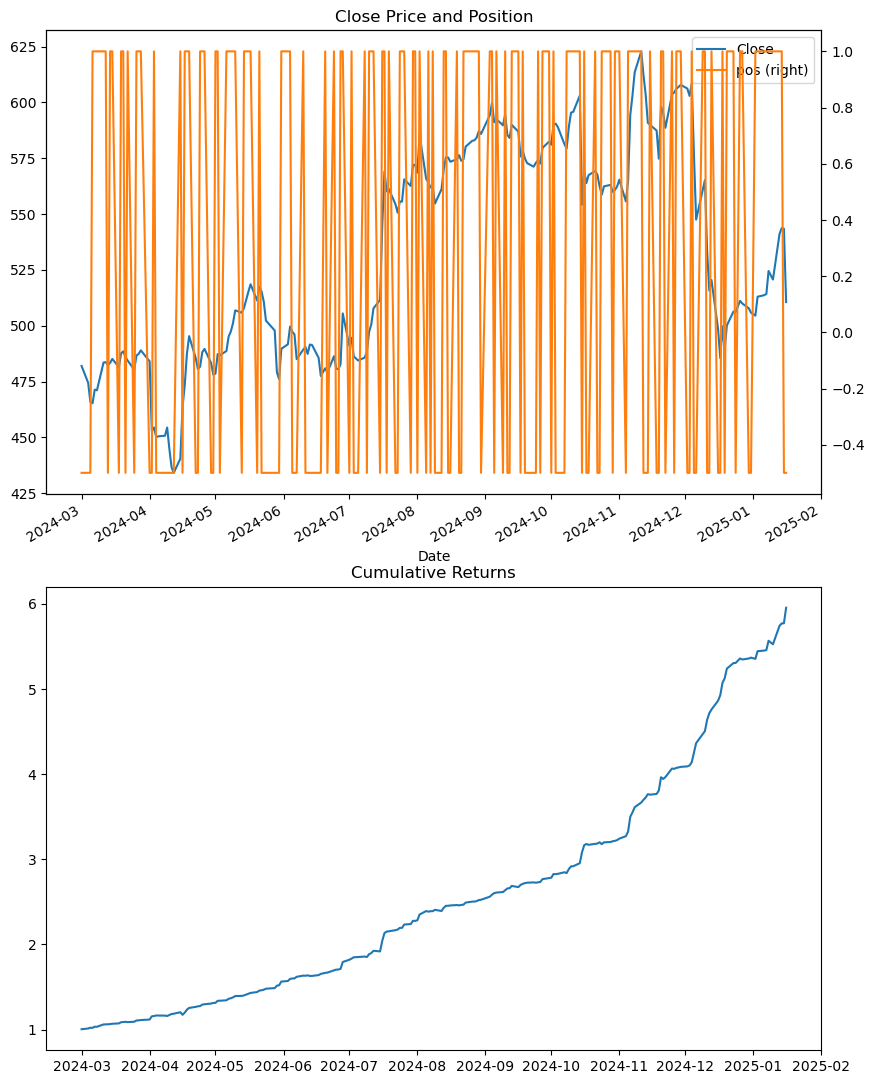

In [6]:
stock = 'UNH'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def xgb_strategy(data):
    df1 = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    start_date = '2022-01-01'
    end_date = '2024-01-21'
    df2 = yf.download(stock, start=start_date, end=end_date)

    # Make sure data is sorted by date
    df2.sort_index(inplace=True)
    df2 = df2.droplevel(1, axis=1) 

    df = pd.concat((df2, df1)) 

    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Drop NaN values
    df.dropna(inplace = True)

    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 14).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 14).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 14).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 14).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 14).min()) /
                     (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 14).max() - df['Close']) /
                         (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    
    df['direction'] = (df['Returns'] > 0).astype(int)
        
    # Drop NaN values
    df.dropna(inplace = True)

    # Feature Selection Approaches
    features = [col for col in df.columns if col not in ['Returns', 'direction']]
    train_data = df.loc[:'2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))

    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = XGBClassifier(eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    predictions = model.predict(X_test)
    test_data['pos'] = np.where(predictions == 0, -0.5, 1)
    test_data['xgb_returns'] = test_data['pos'] * test_data['Returns']

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['xgb_returns'].sum())
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    test_data[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_title("Close Price and Position")

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(test_data['xgb_returns'].cumsum()))
    axes[1].set_title("Cumulative Returns")

    print(f"Cumulative Return: {cumulative_return:.4f}") 

xgb_strategy(src)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Axes: xlabel='Date'>

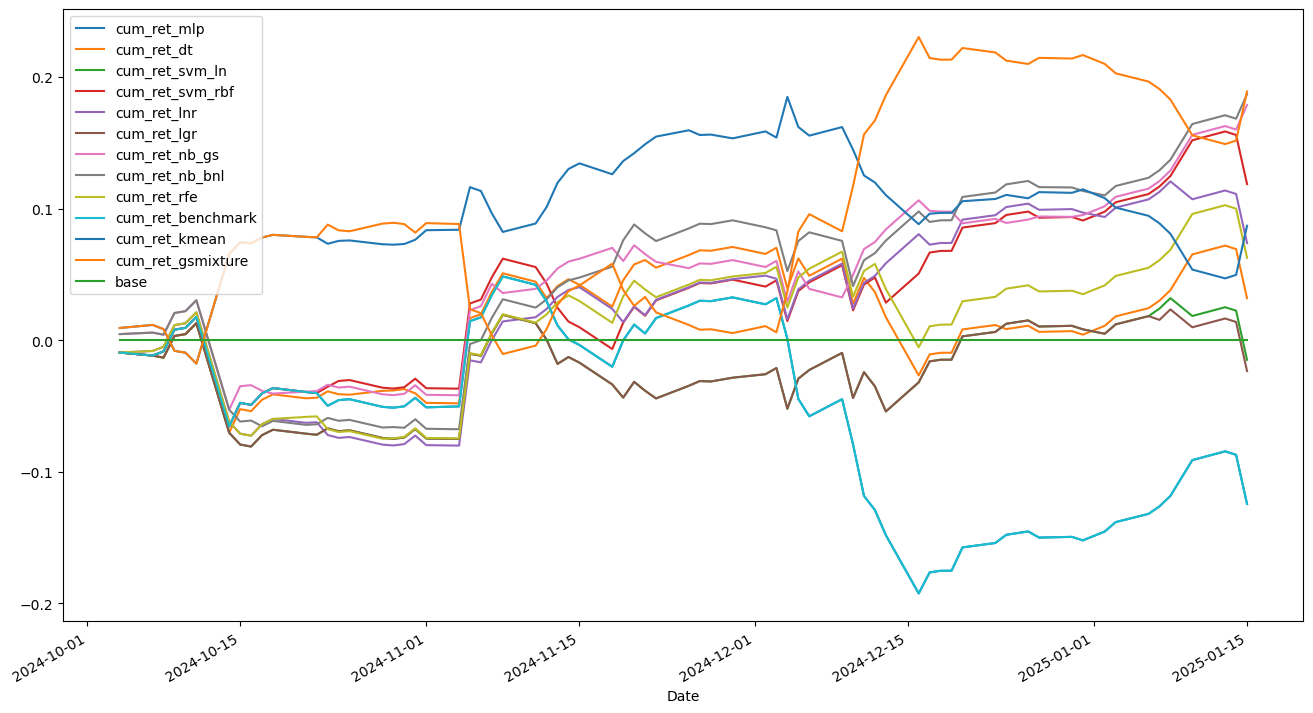

In [ ]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols  

def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df 

def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Avg_Price'] = (df['Close'] + df['Open']) / 2
    df['Returns'] = np.log(df['Avg_Price'] / df['Avg_Price'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    df = df.dropna()
    df = scale_columns(df, 10)
    return df 

def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    return train_test_split(df[feature_cols], df[['Target', 'Target_Returns']], test_size=0.3, shuffle=False)


global models
seed = 12345
supervised_models = {
    'mlp': sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 70, 50), activation='logistic', max_iter=1000, random_state=seed),
    'dt': sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=seed),
    'svm_ln': SVC(kernel='linear', random_state=seed),
    'svm_rbf': SVC(kernel='rbf', random_state=seed),
    'lnr': LinearRegression(),
    'lgr': LogisticRegression(),
    'nb_gs': GaussianNB(),
    'nb_bnl': BernoulliNB(),
    'rfe': RandomForestClassifier(n_estimators=100, random_state=seed)
}

def fit_and_predict_supervised_models(X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    for model_name, model in supervised_models.items():
        model.fit(X_train, y_train['Target'])
        y_test[f'pos_{model_name}'] = model.predict(X_test)
        y_test[f'pos_{model_name}'] = np.sign(y_test[f'pos_{model_name}'])
        y_test[f'pos_{model_name}'] = np.where(y_test[f'pos_{model_name}'] < -0.5, -0.5, y_test[f'pos_{model_name}'])
        df_result[f'ret_{model_name}'] = y_test[f'pos_{model_name}'] * y_test['Target_Returns']
        df_result[f'cum_ret_{model_name}'] = df_result[f'ret_{model_name}'].cumsum()

    df_result['ret_benchmark'] = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = df_result['ret_benchmark'].cumsum()

    for col in df_result.columns:
        if col[:3] != 'cum':
            df_result = df_result.drop(columns=[col])

    return df_result

unsupervised_models = {
    'kmean': KMeans(n_clusters=2, random_state=seed),
    'gsmixture': GaussianMixture(n_components=2, random_state=seed)
}

def fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=None):
    # Use a new DataFrame or a copy of the provided one
    df_result = pd.DataFrame() if save_to is None else save_to.copy()

    for model_name, model in unsupervised_models.items():
        # Fit the model on training data
        model.fit(X_train)
        predictions = model.predict(X_test)
        signal = np.sign(predictions)
        signal = np.where(signal < 1, -0.5, signal)

        ret_original = signal * y_test['Target_Returns']
        cum_ret_original = ret_original.cumsum()

        flipped_signal = -signal
        ret_flipped = flipped_signal * y_test['Target_Returns']
        cum_ret_flipped = ret_flipped.cumsum()

        # Select the alignment with the higher final cumulative return
        if cum_ret_flipped.iloc[-1] > cum_ret_original.iloc[-1]:
            chosen_cum_ret = cum_ret_flipped
        else:
            chosen_cum_ret = cum_ret_original

        # Store the chosen cumulative returns for the model
        df_result[f'cum_ret_{model_name}'] = chosen_cum_ret

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = benchmark_ret.cumsum()

    # Remove any non-cumulative columns
    for col in list(df_result.columns):
        if not col.startswith('cum'):
            df_result.drop(columns=[col], inplace=True)

    return df_result 

data = pd.read_csv("UNH.csv", parse_dates=True, index_col=0).dropna()
data = preprocess_data(data)
X_train, X_test, y_train, y_test = stock_train_test_split(data)
df_result = fit_and_predict_supervised_models(X_train, X_test, y_train, y_test)
df_result = fit_and_predict_unsupervised_models(X_train, X_test, y_train, y_test, save_to=df_result)
df_result 

df_result['base'] = np.zeros((len(df_result), 1))
df_result.plot(figsize=(16,9))
